# Assignment_2
## PART1

Steps to Follow for Classification
1. Read your classification data. Training and test split given on your dataset.
2. Extract features for each image in the training set (image size, Grayscale, Gabor,
etc.).
3. Train your ID3 decision tree model with respect to your features.
4. For each given test sample measure the features’ quality.
5. Compute and report your ”Accuracy”, ”Precision”, ”Recall” and ”F1 Score” of
your different ID3 model parameters. Finally, write the rules of your best-performing
decision tree model with respect to these four metrics mentioned in ”Classification
Performance Metric”.
6. Report your findings in the ”Error Analysis for Classification” section.

### Import Statements

In [36]:
#importing necessary libraries
import numpy as np
import cv2
import os
import pandas as pd
import sklearn

### Reading the Data

In [125]:
#function for loading all images from a folder
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [38]:
#creates flower images list
def create_dataset_img_array(dataset_location,types):
    images_all_types = []
    for flower_type in types:
        dataset_location1 = dataset_location + flower_type + "/"
        images_all_types.append(load_images_from_folder(dataset_location1))
    return images_all_types

In [126]:
#paths of data
test_data = "C:/Users/Asus/Desktop/BBM409/as2/flowers/test/"
validation_data = "C:/Users/Asus/Desktop/BBM409/as2/flowers/validation/"
train_data = "C:/Users/Asus/Desktop/BBM409/as2/flowers/train/"
#data type
file_type = ".jpg"
#list of flower types
flower_types = ["astilbe","bellflower","carnation","daisy","dandelion","iris","rose","sunflower","tulip","water_lily"]
#create img lists
train_images = create_dataset_img_array(train_data,flower_types)
validation_images = create_dataset_img_array(validation_data,flower_types)
test_images = create_dataset_img_array(test_data,flower_types)


In [63]:
#printing lengths of the image arrays to make sure the reading is done correctly
print(len(train_images))
print(len(train_images[0]))

print(len(validation_images))
print(len(validation_images[0]))

print(len(test_images))
print(len(test_images[0]))

#printing shapes of the images to make sure they are same
print(train_images[0][0].shape)
print(validation_images[0][0].shape)
print(test_images[0][0].shape)

10
600
10
50
10
50
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


In [6]:
#showing a random image from dataset to make sure that reading is done right
img1 = test_images[2][2]
cv2.imshow("image1", img1)
cv2.waitKey(0)
cv2.destroyAllWindows()

### Feature Selection

Image Size: You can resize images to a small size for a short training time.  
Color space: You can change the color space of images (RGB, HSV, and Grayscale).  
Shape features: Shape is an important and powerful feature for image processes.  
You can use shape information extracted using a histogram of edge detection. Edge  
information in the image is obtained by using the Canny Edge Detector, Sobel Filter,  
and Laplacian Filter.  
Texture features: The texture feature is extracted usually using a filter-based method.  
The Gabor filter is a frequently used filter in texture extraction.  
Also, you can apply smoothing, sharpening, and noise-removing methods. You can  
use more than one feature by concatenating them.  

#### Choose Feature Parameters

In [127]:
#Choose to tune the parameters below as wished

#image preprocessing 
image_size_percentage = 25 #choose a percentage to resize image 
img_size = int((test_images[0][0].shape[0]) * image_size_percentage /100)
smoothing_type= "gaussian" #[False,"blur","gaussian","bilateral"]
noise_removing = "true_colored" #[False, "true_colored"] 
#Above steps will applied one after another and will result one resized,smoothed,noise_removed image with shape(img_size,img_size,3)

#texture features
#gabor filter use it before edge detection
texture_type = "gabor" #[false, "gabor"]
#shape features,edge detection. canny, sobel filter, laplacian filter
edge_type = "canny" #[false,"canny","sobel","laplacian"] 
#edge_detection will be applied after texture operation and will result
# one image with shape(img_size,img_size) or (img_size*2,img_size)if the type is sobel

#color features [grayscale,BGR,HSV] 
#must choose at least one of them
color_BGR = False # use bgr image channels as feature => 3 features img is already preprocessed bgr 
color_HSV = False # use hsv image channels as feature => 3 features convert bgr to hsv
color_gray = True #use grayscale of image as feature if chosen convert bgr to grayscale



#### Feature Extraction Functions

In [43]:
#resize the given image
def resize_img(img):
    return cv2.resize(img, (img_size,img_size))
    

In [44]:
#smooths the image blur, gaussian or bilateral smoothing
def smooth_img(img, smoothing_type): 
    if(smoothing_type == "blur"):
        return cv2.blur(img,(5,5))
    if(smoothing_type == "gaussian"):
        return cv2.GaussianBlur(img,(5,5),0)
    if(smoothing_type == "bilateral"):
        return cv2.bilateralFilter(img,9)
    if(smoothing_type==False):
        return img

In [45]:
#removes noise from image
def noise_remove(img, remove_type):
    if(remove_type == "true_colored"):
        return cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)
    if(remove_type==False):
        return img

In [46]:
#returns color channels in an image as a combined array
def return_channels(img):
    #obtaining the source channels
    blue_channel = img[:,:,0] #H or B
    green_channel = img[:,:,1] #S or G
    red_channel = img[:,:,2] #V or R
    return [blue_channel, green_channel, red_channel]

In [47]:
#changes color space of given BGR image
def change_img_color(img,color_type):
    if(color_type == "grayscale"):
        return cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) 
    if(color_type == "HSV"):
        return cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    if(color_type=="BGR"):
        return img

In [48]:
#edge detection in an image its recommended to use some texture extraction func. before this
# sobel returns an array [sobelx,sobely] as a concatenated one array
def edge_detection_img(img, edge_type): 
    img1 = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) 
    if(edge_type == "canny"):
        return cv2.Canny(img1,100,200)
    if(edge_type == "sobel"):
        sobelx = cv2.Sobel(img1,cv2.CV_64F,1,0,ksize=5)
        sobely = cv2.Sobel(img1,cv2.CV_64F,0,1,ksize=5)
        return np.concatenate((sobelx,sobely),axis=0)
    if(edge_type == "laplacian"):
        return cv2.Laplacian(img1,cv2.CV_64F)
    if(edge_type==False):
        return img
    

In [49]:
#texture extraction from image using gabor filters 
#returns one image with edges highlighted 
def texture_img(img, texture_type): 
    if(texture_type == "gabor"):
        # produces set of GaborFilters 
        filters = []
        num_filters = 16
        ksize = 35  
        sigma = 3.0  
        lambd = 10.0
        gamma = 0.5
        psi = 0  
        for theta in np.arange(0, np.pi, np.pi / num_filters): 
            kern = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_64F)
            kern /= 1.0 * kern.sum() 
            filters.append(kern)
        # create a numpy array the same size as our input image
        newimage = np.zeros_like(img)
        # Starting with a blank image, we loop through the images and apply our Gabor Filter
        # On each iteration, we take the highest value (super impose), until we have the max value across all filters
        # The final image is returned
        depth = -1 # remain depth same as original image
        
        for kern in filters:  # Loop through the kernels in our GaborFilter
            image_filter = cv2.filter2D(img, depth, kern)  #Apply filter to image
            # Using Numpy.maximum to compare our filter and cumulative image, taking the higher value (max)
            np.maximum(newimage, image_filter, newimage)
        return newimage
    if(texture_type==False):
        return img

#### Extracting Features from first Image in test Dataset and Creating Columns of Dataframe

In [104]:
#it returns the features for the image except label
def create_feature_img_list(img):
    #it is a list of images of each extracted feature
    img_feature_list = []
    
    #changing type to numpy array
    img_np = np.array(img)
    #resizing the image
    img_np = resize_img(img_np)
    #smooth the rgb img
    img_np = smooth_img(img_np,smoothing_type)
    #remove the noises from rgb image
    img_np = noise_remove(img_np, noise_removing)
    
    #for edge information extraction
    #if both edge_type and texture type is false its same as img_np
    if not (edge_type==False and texture_type==False):
        img_np_e = texture_img(img_np, texture_type)
        img_np_e = edge_detection_img(img_np,edge_type)
        img_feature_list.append(img_np_e)

    #there is no need to use extra rgb channels when we already have smoothed,noise removed rgb img
    #so hsv and grayscale images will be created from rgb img

    if(color_BGR == True):
        img_feature_list.append(img_np)
    if(color_HSV == True):
        img_feature_list.append(change_img_color(img_np,"HSV"))
    if((color_gray == True) and (edge_type==False and texture_type==False)):
        img_feature_list.append(change_img_color(img_np,"grayscale"))
    #num of features that has been extracted in terms of img 
    img_num_features = len(img_feature_list)
    
    img_feature_list_flattened_averaged =[]
    for img in img_feature_list:
        #flatten the image array
        img_f = np.ravel(img)
        #Averaged the neighbour 4 number in the array to decrease feature numbers for decision tree 
        #average over array with partition size 4 over its columns
        img_f_a = np.mean(img_f.reshape(-1, 4), axis=1, dtype=int)
        img_feature_list_flattened_averaged.append(img_f_a)

    return img_feature_list_flattened_averaged    
    

#### Creating Test DataFrame

In [128]:
#using the first image in test dataset
img = test_images[0][0]

img_feature_list_flattened_averaged = create_feature_img_list(img)
  #combine all elements in the list
arr = np.hstack(img_feature_list_flattened_averaged)
#concatenate with 0 because test_data[0][0] has 0 as label
#indexes has only features for the 1st img in test_data
indexes_test= np.concatenate((arr,0),axis=None) 

#creating column names of the dataframe
df_columns=[]
for i in range(len(img_feature_list_flattened_averaged)):
    img_name = "img"+str(i)+"_"
    img_len = len(img_feature_list_flattened_averaged[i])
    for k in range(img_len):
        img_name1 = img_name + str(k)
        df_columns.append(img_name1)
            
#add labels as target column to the dataframe
df_columns.append("target")

In [129]:
for i in range(len(test_images)):#10
    img_label = i
    for j in range(len(test_images[i])):#50 for test images
        img = test_images[i][j]
        img_feature_list_flattened_averaged = create_feature_img_list(img)
        #combine all elements in the list
        arr = np.hstack(img_feature_list_flattened_averaged)
        
        
        concat_arr = np.concatenate((arr,img_label),axis=None)
        indexes_test = np.vstack ((indexes_test, concat_arr) )


#using slicing[1:] because first image repeated twice    
df_test = pd.DataFrame(indexes_test[1:], columns=df_columns)

#shows first 5 values from dataframe
df_test.head(5)

,img0_0,img0_1,img0_2,img0_3,img0_4,img0_5,img0_6,img0_7,img0_8,img0_9,...,img0_1015,img0_1016,img0_1017,img0_1018,img0_1019,img0_1020,img0_1021,img0_1022,img0_1023,target
0,0,0,0,63,0,0,0,0,0,63,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,63,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,63,0,0,0,63,63,63,63,0,...,63,0,0,0,0,127,0,0,0,0


In [130]:
#checking the size of the dataframe
print(df_test.shape)

(500, 1025)


#### Creating Train Dataframe

In [131]:
#Since img size in the test and train dataframe is same number of features will be the same for both
#using the first image in train dataset
img = train_images[0][0]

img_feature_list_flattened_averaged = create_feature_img_list(img)
#combine all elements in the list
arr = np.hstack(img_feature_list_flattened_averaged)

#concatenate with 0 because test_data[0][0] has 0 as label
#indexes has only features for the 1st img in train_data
indexes_train= np.concatenate((arr,0),axis=None) 

In [132]:
for i in range(len(train_images)):#10
    img_label = i
    for j in range(len(train_images[i])):#600 for train images
        img = train_images[i][j]
        img_feature_list_flattened_averaged = create_feature_img_list(img)
        #combine all elements in the list
        arr = np.hstack(img_feature_list_flattened_averaged)
        
        concat_arr = np.concatenate((arr,img_label),axis=None)
        indexes_train = np.vstack ((indexes_train, concat_arr) )

#using slicing[1:] because first image repeated twice    
#cloumns will be same as the test dataframe
df_train = pd.DataFrame(indexes_train[1:], columns=df_columns)

#shows last 5 values from dataframe
df_train.tail(5)

,img0_0,img0_1,img0_2,img0_3,img0_4,img0_5,img0_6,img0_7,img0_8,img0_9,...,img0_1015,img0_1016,img0_1017,img0_1018,img0_1019,img0_1020,img0_1021,img0_1022,img0_1023,target
5995,0,0,0,63,0,0,0,0,0,0,...,0,0,0,0,63,0,0,0,0,9
5996,0,63,0,63,63,63,0,0,0,0,...,0,0,63,63,0,0,63,0,0,9
5997,0,0,0,0,0,0,63,0,63,0,...,0,0,63,63,0,63,0,63,0,9
5998,0,63,0,0,63,0,0,0,0,0,...,0,0,63,63,0,0,0,0,0,9
5999,0,0,0,0,0,63,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


In [133]:
#checking the size of the dataframe
print(df_train.shape)

(6000, 1025)


In [134]:
#shows first 5 values from dataframe
df_train.head(5)

,img0_0,img0_1,img0_2,img0_3,img0_4,img0_5,img0_6,img0_7,img0_8,img0_9,...,img0_1015,img0_1016,img0_1017,img0_1018,img0_1019,img0_1020,img0_1021,img0_1022,img0_1023,target
0,0,63,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,63,63,0,0,63,63,...,0,0,0,0,0,0,63,0,63,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,63,0


#### Changing DataFrame Values using Entropy Based Binning

In [135]:
#since the image values are continous this approch will a new categorical feature indicating the bins.
#entropy_based_binning function takes the dataframe, the feature to be binned, 
# the target variable, and the desired number of bins as input. It then iterates over potential split points, 
# calculates the entropy for each subset created by the split, and chooses the split point that minimizes the weighted average entropy.
def entropy_based_binning(data, target, num_bins):
    binned_data = pd.DataFrame()

    # Iterate over all features except the last one
    for feature in data.columns[:-1]:
        # Sort data by the feature
        sorted_data = data.sort_values(by=feature)
        
        # Find potential split points
        split_points = np.linspace(sorted_data[feature].min(), sorted_data[feature].max(), num_bins + 1)
        
        # Initialize variables
        best_split_point = None
        min_entropy = float('inf')
        
        # Iterate over potential split points
        for split_point in split_points:
            # Split data into two subsets
            subset1 = sorted_data[sorted_data[feature] <= split_point]
            subset2 = sorted_data[sorted_data[feature] > split_point]
            
            # Calculate entropy for each subset
            entropy1 = calculate_entropy(subset1[target])
            entropy2 = calculate_entropy(subset2[target])
            
            # Calculate weighted average entropy
            weighted_entropy = (len(subset1) / len(sorted_data)) * entropy1 + (len(subset2) / len(sorted_data)) * entropy2
            
            # Update best split point if this split is better
            if weighted_entropy < min_entropy:
                min_entropy = weighted_entropy
                best_split_point = split_point
        
        # Use the best split point to bin the data
        binned_data[feature + '_binned'] = pd.cut(data[feature], bins=[float('-inf'), best_split_point, float('inf')], labels=[0, 1])
        
    binned_data[target] = data[target]

    return binned_data

def calculate_entropy(labels):
    # Calculate entropy of a set of labels
    value_counts = labels.value_counts(normalize=True)
    probabilities = value_counts.values
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy


In [136]:
#bin the features using their entropy
#continous values will converted to binary values
num_bins = 8
binned_train = entropy_based_binning(df_train, 'target', num_bins)
binned_test = entropy_based_binning(df_test, 'target', num_bins)


In [114]:
#shows first 5 values from dataframe
binned_train.head(5)

,img0_0_binned,img0_1_binned,img0_2_binned,img0_3_binned,img0_4_binned,img0_5_binned,img0_6_binned,img0_7_binned,img0_8_binned,img0_9_binned,...,img1_3063_binned,img1_3064_binned,img1_3065_binned,img1_3066_binned,img1_3067_binned,img1_3068_binned,img1_3069_binned,img1_3070_binned,img1_3071_binned,target
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,1,0,0,1,1,...,0,0,0,1,1,1,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,1,1,1,1,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,1,0,0,0


In [115]:
binned_test.head(5)

,img0_0_binned,img0_1_binned,img0_2_binned,img0_3_binned,img0_4_binned,img0_5_binned,img0_6_binned,img0_7_binned,img0_8_binned,img0_9_binned,...,img1_3063_binned,img1_3064_binned,img1_3065_binned,img1_3066_binned,img1_3067_binned,img1_3068_binned,img1_3069_binned,img1_3070_binned,img1_3071_binned,target
0,0,0,0,1,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,1,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,0,1,1,1,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,1,1,0
4,0,1,0,0,0,1,0,1,1,0,...,1,1,0,1,0,1,1,1,1,0


#### ID3 Algorithm 

In [120]:
#calculates information gain using entropy
def calculate_information_gain(data1,data2):
    total_length = len(data1) + len(data2)
    p_data1 = len(data1) / total_length
    p_data2 = len(data2) / total_length
    
    data1_target_column  = data1[:, -1]
    _, data1_counts = np.unique(data1_target_column , return_counts=True)

    probabilities = data1_counts / data1_counts.sum()
    data1_entropy = sum(probabilities * -np.log2(probabilities))
    
    data2_target_column  = data2[:, -1]
    _, data2_counts = np.unique(data2_target_column , return_counts=True)

    probabilities1 = data2_counts / data2_counts.sum()
    data2_entropy = sum(probabilities1 * -np.log2(probabilities1))

    info_gain = (p_data1 * data1_entropy + p_data2 * data2_entropy)

    return info_gain

#determines if given data is pure or not
def is_data_pure(data):
    label_col = data[:, -1]
    unique_classes = np.unique(label_col)
    if len(unique_classes) == 1:
        return True
    else:
        return False

#finds potential splits for the given feature
def find_potential_splits(data):
    potential_splits = {}
    _, num_columns = data.shape
    for col_index in range(num_columns - 1):  # excluding the last column which is the target
        values = data[:, col_index]
        unique_values = np.unique(values)
        potential_splits[col_index] = unique_values

    return potential_splits

#fins the optimal splits from the potential splita
def find_optimal_split(data, splits):
    first_iteration = True
    for col_index in splits:
        for value in splits[col_index]:
            data_below, data_above = split_data(data, column_to_split=col_index, value_to_split=value)

            current_info_gain = calculate_information_gain(data_below,data_above)
    
            if first_iteration or current_info_gain <= best_info_gain:
                first_iteration = False

                best_info_gain = current_info_gain
                best_split_column = col_index
                best_split_value = value

    return best_split_column, best_split_value

#splits the data into two parts
def split_data(data, column_to_split, value_to_split):
    split_column_values = data[:, column_to_split]

    data_below = data[split_column_values == value_to_split]
    data_above = data[split_column_values != value_to_split]

    return data_below, data_above

#creates a leaf to the tree
def create_leaf(data):
    label_column = data[:, -1]
    unique_classes, class_counts = np.unique(label_column, return_counts=True)
    index = class_counts.argmax()
    leaf = unique_classes[index]
    return leaf

#builds tree
def build_decision_tree(df,counter=0, min_samples=8,max_depth=5):
    # data preparations
    if counter == 0:
        global HEADERS
        HEADERS = df.columns
        data = df.values
    else:
        data = df

    # Base cases
    if (is_data_pure(data)) or (len(data) < min_samples) or (counter == max_depth):
        leaf = create_leaf(data)
        return leaf


    # Recursive part
    else:
        counter += 1

        potential_splits = find_potential_splits(data)
        split_column, split_value = find_optimal_split(data, potential_splits)
        data_below, data_above = split_data(data, split_column, split_value)

        # check for empty data
        if len(data_below) == 0 or len(data_above) == 0:
            leaf = create_leaf(data)
            return leaf

        # determine question
        feature_name = HEADERS[split_column]
        question = "{} = {}".format(feature_name, split_value)

        # instantiate sub-tree
        sub_tree = {question: []}

        # find answers (recursion)
        yes_answer = build_decision_tree(data_below, counter, min_samples,max_depth)
        no_answer = build_decision_tree(data_above, counter, min_samples,max_depth)

        # If the answers are the same, then there is no point in asking the qestion.
        # This could happen when the data is classified even though it is not pure
        # yet (min_samples or max_depth base case).
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)

        return sub_tree


def predict_example(example, decision_tree):
    # decision_tree is just a root node
    if not isinstance(decision_tree, dict):
        return decision_tree

    question = list(decision_tree.keys())[0]
    feature, operator, value = question.split(" ")

    # ask question
    if operator == "<=":
        if example[feature] <= float(value):
            result = decision_tree[question][0]
        else:
            result = decision_tree[question][1]

    # feature is categorical
    else:
        if str(example[feature]) == value:
            result = decision_tree[question][0]
        else:
            result = decision_tree[question][1]

    # base case
    if not isinstance(result, dict):
        return result

    # recursive part
    else:
        residual_tree = result
        return predict_example(example, residual_tree)


def make_predictions(dataframe, decision_tree):
    predictions = dataframe.apply(predict_example, args=(decision_tree,), axis=1)
    return predictions



In [121]:
#build tree with paramters rgb=true, 4096 features for result comparison
tree = build_decision_tree(binned_train,max_depth=1)

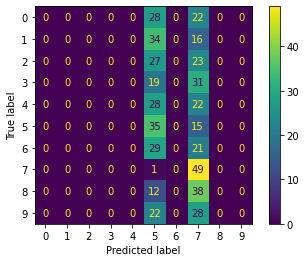

max depth of tree is 20, accuracy is 0.168
max depth of tree is 20, macro precision is 0.033
max depth of tree is 20, macro recall is 20 0.168
max depth of tree is 20, macro f1 score is 0.056


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [122]:
#result of 
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
import matplotlib.pyplot as plt
prediction_list2 =[]
predictions = make_predictions(binned_test, tree)
prediction_list2.append(predictions)
cm = sklearn.metrics.confusion_matrix(binned_test["target"], predictions, labels=[0,1,2,3,4,5,6,7,8,9])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4,5,6,7,8,9])
disp.plot()
plt.show()
accuracy = sklearn.metrics.accuracy_score(binned_test["target"], predictions)
precision = sklearn.metrics.precision_score(binned_test["target"], predictions,average="macro")
recall = sklearn.metrics.recall_score(binned_test["target"], predictions,average="macro")
f1 = sklearn.metrics.f1_score(binned_test["target"],predictions,average="macro")
print(f"accuracy is {round(accuracy, 3)}")
print(f"macro precision is {round(precision, 3)}")
print(f"macro recall is {round(recall, 3)}")
print(f"macro f1 score is {round(f1, 3)}")


In [96]:
#Building tree with different max_depth values and printing out time to calculate latency for each tree
#input data is an image using hyperparameters with size of 64*16 = 1024 features
"""
image_size_percentage = 25 
smoothing_type= "gaussian" 
noise_removing = "true_colored" 
texture_type = "gabor" 
edge_type = "canny" 
color_BGR = False 
color_HSV = False
color_gray = True 
"""

from datetime import datetime

max_depth_list = [1,3,5,8,10,15,20]
prediction_list =[]
for n in max_depth_list:
    print(n)
    tree = build_decision_tree(binned_train,max_depth=n)
    predictions = make_predictions(binned_test, tree)
    prediction_list.append(predictions)
    print(datetime.now())



1
2023-12-09 16:23:02.808498
3
2023-12-09 16:25:23.206374
5
2023-12-09 16:29:08.658931
8
2023-12-09 16:34:29.764639
10
2023-12-09 16:41:16.988082
15
2023-12-09 16:49:47.464440
20
2023-12-09 16:59:40.565643


Confusion matrix of tree with max depth 1


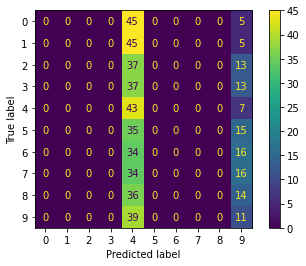

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


max depth of tree is 1, accuracy is 0.108
max depth of tree is 1, macro precision is 0.021
max depth of tree is 1, macro recall is 1 0.108
max depth of tree is 1, macro f1 score is 0.033
Confusion matrix of tree with max depth 3


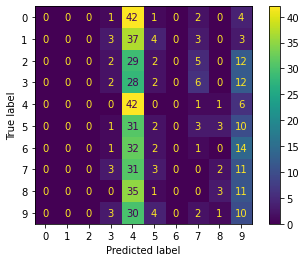

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


max depth of tree is 3, accuracy is 0.118
max depth of tree is 3, macro precision is 0.075
max depth of tree is 3, macro recall is 3 0.118
max depth of tree is 3, macro f1 score is 0.057
Confusion matrix of tree with max depth 5


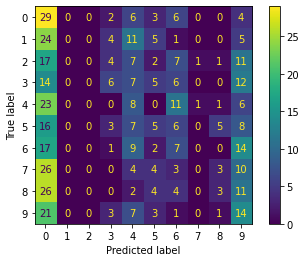

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


max depth of tree is 5, accuracy is 0.144
max depth of tree is 5, macro precision is 0.116
max depth of tree is 5, macro recall is 5 0.144
max depth of tree is 5, macro f1 score is 0.107
Confusion matrix of tree with max depth 8


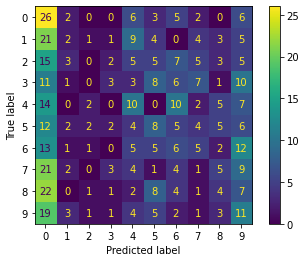

max depth of tree is 8, accuracy is 0.142
max depth of tree is 8, macro precision is 0.129
max depth of tree is 8, macro recall is 8 0.142
max depth of tree is 8, macro f1 score is 0.117
Confusion matrix of tree with max depth 10


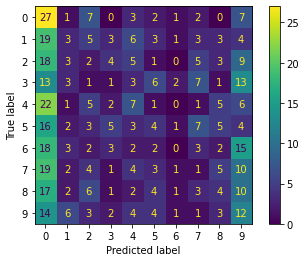

max depth of tree is 10, accuracy is 0.122
max depth of tree is 10, macro precision is 0.097
max depth of tree is 10, macro recall is 10 0.122
max depth of tree is 10, macro f1 score is 0.094
Confusion matrix of tree with max depth 15


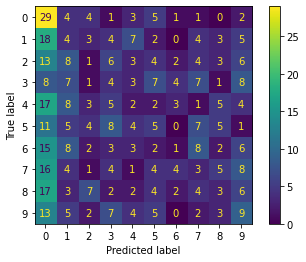

max depth of tree is 15, accuracy is 0.122
max depth of tree is 15, macro precision is 0.097
max depth of tree is 15, macro recall is 15 0.122
max depth of tree is 15, macro f1 score is 0.097
Confusion matrix of tree with max depth 20


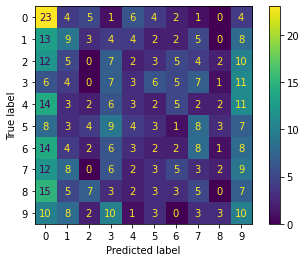

max depth of tree is 20, accuracy is 0.12
max depth of tree is 20, macro precision is 0.092
max depth of tree is 20, macro recall is 20 0.12
max depth of tree is 20, macro f1 score is 0.097


In [102]:
#import statements for calculating metrics and displaying confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
import matplotlib.pyplot as plt

for i in range(len(prediction_list)):
    predictions = prediction_list[i]
    n = max_depth_list[i]
    print(f"Confusion matrix of tree with max depth {n}")
    cm = sklearn.metrics.confusion_matrix(binned_test["target"], predictions, labels=[0,1,2,3,4,5,6,7,8,9])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4,5,6,7,8,9])
    disp.plot()
    plt.show()
    accuracy = sklearn.metrics.accuracy_score(binned_test["target"], predictions)
    precision = sklearn.metrics.precision_score(binned_test["target"], predictions,average="macro")
    recall = sklearn.metrics.recall_score(binned_test["target"], predictions,average="macro")
    f1 = sklearn.metrics.f1_score(binned_test["target"],predictions,average="macro")
    print(f"max depth of tree is {n}, accuracy is {round(accuracy, 3)}")
    print(f"max depth of tree is {n}, macro precision is {round(precision, 3)}")
    print(f"max depth of tree is {n}, macro recall is {n} {round(recall, 3)}")
    print(f"max depth of tree is {n}, macro f1 score is {round(f1, 3)}")
        

### Error Analysis For Classification
For the first tree construction I used parameters below:  
image_size_percentage = 25  
smoothing_type= "gaussian"  
noise_removing = "true_colored"  
texture_type = "gabor"  
edge_type = "canny"  
color_BGR = False  
color_HSV = False  
color_gray = True  
  
This parameters resulted 1024 features. (one smoothed, nosie removed, gabor filter and canny edge detection applied grayscale image which column size reduced to 1/4)  
Using 1024 features:  
Accuracy levels for the data using ID3 algorithm varied between 10.1% to 14.4% with this data.  
entropy based binning with bin size=8  
when tree_depth = 1, accuracy = 0.108, 1 minutes  
when tree_depth = 3, accuracy = 0.118, 2 minutes  
when tree_depth = 5, accuracy = 0.144, 4 minutes  
when tree_depth = 8, accuracy = 0.142, 5 minutes  
when tree_depth = 10, accuracy = 0.122, 7 minutes  
when tree_depth = 15, accuracy = 0.122, 8 minutes  
when tree_depth = 20, accuracy = 0.120, 10 minutes  
   
It can be seen that as max tree depth increases latency increases too this is caused becuase tree gets larger.  
It can be seen that max accuracy was 0.144 with the max tree depth 5.  
Until the max depth 5,accuracy raised from 0.108 to 0.144 this proves that the tree model learned more features from data when the  
depth of the tree raised until 5.   
After max depth 5 accuracy decreased until the depth 20 from 0.144 to 0.12. This shows after depth 5 model gets more complex but starts to overfitting.  
That's why the optimal tree depth for the data is 5 when the best accuracy achieved.  
But most of the times observing the accuracy alone is not enough for deciding the performance of the model.  
I used macro averaging method for calculating precision, recall and f1 score. Which gets means of sum of each classes results.   
Higher precision means that an algorithm returns more relevant results than irrelevant ones.  
Higher recall means that an algorithm returns most of the relevant results.  
High precision and high recall are desirable, but there may be a trade-off between the two metrics in some cases.  
So we use f1 score metrics to compare them together.  
Meanwhile higher f1 score indicates the strong overall performance of a binary classification model.  
If we further observe the precision, recall and f1 score results:  
when tree_depth = 1, precision = 0.021 , recall = 0.108 , f1 score = 0.033  
when tree_depth = 3, precision = 0.075 , recall = 0.118 , f1 score = 0.057  
when tree_depth = 5, precision = 0.116 , recall = 0.144 , f1 score = 0.107  
when tree_depth = 8, precision = 0.129 , recall = 0.142 , f1 score = 0.117  
when tree_depth = 10, precision = 0.097 , recall = 0.122 , f1 score = 0.094  
when tree_depth = 15, precision = 0.097 , recall = 0.122 , f1 score = 0.097  
when tree_depth = 20, precision = 0.092 , recall = 0.120 , f1 score = 0.097  
It can be seen that max f1 score was 0.117 with the max tree depth 8.  
Until the max depth 8,f1 score raised from 0.038 to 0.117 this proves that the tree model learned more features from data when the  
depth of the tree raised until 8.  
After max depth 8 f1 score decreased until the depth 20 from 0.144 to 0.12. This shows after depth 5 model gets more complex but starts to overfitting.  
Same can be observed with max depth 8 with best precision and max depth 5 with best recall.    
We can conclude max depth value 5 or 8 for constructing the decision tree model results best model for the data.

For the second tree construction I used parameters below:  
image_size_percentage = 25  
smoothing_type= "gaussian"  
noise_removing = "true_colored"   
texture_type = "gabor"  
edge_type = "canny"  
color_BGR = True  
color_HSV = False  
color_gray = True  
   
This parameters resulted 4096 features. (one smoothed, nosie removed, gabor filter and canny edge detection applied grayscale image which column size reduced to 1/4)  
Using 4096 features:  
  
max depth of tree is 1, accuracy is 0.168  
max depth of tree is 1, macro precision is 0.033    
max depth of tree is 1, macro recall is 20 0.168  
max depth of tree is 1, macro f1 score is 0.056  
It took 47 minutes for max depth 1.  
Increasing the number of the paramters from 1024 to 4096 caused latency to increase from 1 minute to 47 minutes.  
Accuarcy observed as 0.168 which is more than the max accuary of the 1024 featured parameters.  
We might conclude that increasion of parameters generaly results better accuracy. But latency increases much more that making model ineffienct to use in time wise.   

There is a part in assignment that says that we should include some misclassified images to the report.  
But even with the model with the highest accuracy 14%, 86% of the images would be missclassified.  
I think the main reason might be the id3 model choose for classification of an image task.  
Further details are discussed in the conclusion part.  


#### Conclusion

Accuracy levels for the data using ID3 algorithm varied between 10% to 20% with this data.  
10% to 20% accuracy is low for this task.  
Even we randomly assign a label for data, probability of it's the correct label for data is 10%.  
So there isn' much difference between randomly guessing the image's label or using decision tree algorithm to predict the label for the image.   
  
Decision trees are not well suited for continous values.  
So entropy based binning used to convert continous values to binary values.  
Since every value in this dataframe will represent a pixel in the image converting this continous values   
to categorical values will result in a decrease in the accuracy.  
  
Accuracy results of the Scikit-learn library vaired around 10% as it can be seen on the part above.  
Even if we raised the max_depth it didn't result any significant change in the accuarcy.  
This also proves that decision trees are not suitable for classification for this data.  
  
Also latency is a big problem using decision trees to classify images.  
When the hyperparameters selected RGB = True or HSV = True each will add img_size * img_size * 3 / 4 parameters to the algorithm  
(3 for three channels and 4 four when we further reduced the size of the columns)  
This increasion in parameters effect latency more than linear O(n) time complexity since we are comparing entropy results with more features.  
In terms of latency it is hard to test this algorithm further and it will be time consuming.  
  
We can conclude that using ID3 or any other decision tree algorthims are not suitable for image classification for this dataset.  
If we were use Neural Networks for this task accuracy will be higher since neural networks can work with continous values.   

Even if we changed the parameters of our tree and further tune them with extensive testing,  
the accuracy of this model would not increase much more further due to the nature of the decision tree.  

#### Using scikit-learn library for comparing Resuts

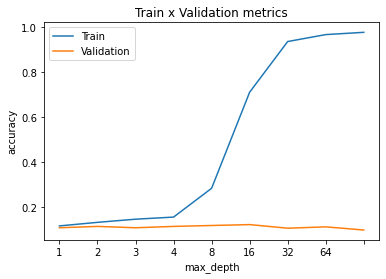

In [90]:
from sklearn.base import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import matplotlib as plt
RANDOM_STATE = 55

min_samples_split_list = [2,10, 30, 50, 100, 200, 300, 700] ## If the number is an integer, then it is the actual quantity of samples,
max_depth_list = [1,2, 3, 4, 8, 16, 32, 64, None] # None means that there is no depth limit.

y_train = pd.DataFrame(binned_train["target"]).to_numpy()
X_train = pd.DataFrame(binned_train.drop(["target"],axis=1)).to_numpy()

y_val = pd.DataFrame(binned_test["target"]).to_numpy()
X_val = pd.DataFrame(binned_test.drop(["target"],axis=1)).to_numpy()

accuracy_list_train = []
accuracy_list_val = []
for max_depth in max_depth_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = DecisionTreeClassifier(max_depth = max_depth,
                                   random_state = RANDOM_STATE).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(max_depth_list )),labels=max_depth_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

## PART2

1. Introduction  
A popular machine learning algorithm for both classification and regression applications is the decision tree.  
By building a tree-like model of decisions based on input features, they imitate the process of making decisions by  
humans. Each leaf node in a decision tree corresponds to the expected result or class, and each internal node in the  
tree represents a decision based on a specific feature.  
  
A decision tree's structure facilitates transparency and interpretability, which makes it simple to comprehend and   
elucidate how a model arrives at a specific prediction. Nevertheless, decision trees can overfit, particularly if  
they get overly intricate and start to pick up noise in the training set. This is the point at which pruning  
is useful.  
  
2. Importance of pruning  
Decision trees can be made simpler by pruning, which involves eliminating some of their branches or nodes.  
Preventing overfitting is the main objective of pruning, which enhances the model's ability to generalize to new,  
unobserved data. When a decision tree is overfitted to the training set, it captures noise or unimportant patterns  
that are poorly generalized.  
  
Our goal with pruning is to achieve a balance between predictive performance and model complexity. Pruning is the  
process of removing branches that don't significantly increase the model's accuracy when applied to omitted data.  
This preserves or even increases the decision tree's predictive ability while ensuring that it is still comprehensible.  

### Functions

In [137]:
# This function returns the first element of pruned leafs
def find_pruned_leaf(training_data):
    return training_data.target.value_counts().index[0]


# This function calculates the predictions which is failed.
def calculate_errors(validation_data4, decision_tree):

    predictions = make_predictions(validation_data4, decision_tree)
    actual_values = validation_data4.target

    # number of errors
    return sum(predictions != actual_values)


# This function pruning the tree which is used in another function called "perform_post_pruning"
def prune_tree(decision_tree, training_data, validation_data3):
    pruned_leaf = find_pruned_leaf(training_data)
    leaf_errors = calculate_errors(validation_data3, pruned_leaf)
    decision_node_errors = calculate_errors(validation_data3, decision_tree)

    # Checking which has the better accuracy if current >= last return pruned
    if leaf_errors <= decision_node_errors:
        return pruned_leaf
    else:
        # Reverting the changes by returning decision tree without making any change
        return decision_tree


# This function filters the data which is called inside the "perform_post_pruning" function's recursive part
def filter_data(data_frame, query):
    feature, operator, value = query.split()

    # Continuous feature
    if operator == "<=":
        filtered_df_true = data_frame[data_frame[feature] <= float(value)]
        filtered_df_false = data_frame[data_frame[feature] > float(value)]

    # Categorical feature
    else:
        filtered_df_true = data_frame[data_frame[feature].astype(str) == value]
        filtered_df_false = data_frame[data_frame[feature].astype(str) != value]

    return filtered_df_true, filtered_df_false


# This function performs the pruning. This is the main function handles everything about pruning and it will be called
# when we want to prune the tree
def perform_post_pruning(decision_tree, training_data, validation_data2):
    # list of yes and no branches
    decision_question = list(decision_tree.keys())[0]
    yes_branch, no_branch = decision_tree[decision_question]

    # base case
    if not isinstance(yes_branch, dict) and not isinstance(no_branch, dict):
        return prune_tree(decision_tree, training_data, validation_data2)

    # recursive part
    else:
        training_data_yes, training_data_no = filter_data(training_data, decision_question)
        validation_data_yes, validation_data_no = filter_data(validation_data2, decision_question)

        if isinstance(yes_branch, dict):
            yes_branch = perform_post_pruning(yes_branch, training_data_yes, validation_data_yes)

        if isinstance(no_branch, dict):
            no_branch = perform_post_pruning(no_branch, training_data_no, validation_data_no)

        decision_tree = {decision_question: [yes_branch, no_branch]}

        return prune_tree(decision_tree, training_data, validation_data2)
    
def calculate_accuracy(dataframe, predictions):
    correct_predictions = predictions == dataframe.target
    accuracy = correct_predictions.mean()
    return accuracy

In [138]:
#Since img size in the test and train dataframe is same number of features will be the same for both
#using the first image in train dataset
img = validation_images[0][0]

img_feature_list_flattened_averaged = create_feature_img_list(img)
#combine all elements in the list
arr = np.hstack(img_feature_list_flattened_averaged)

#concatenate with 0 because test_data[0][0] has 0 as label
#indexes has only features for the 1st img in train_data
indexes_val= np.concatenate((arr,0),axis=None) 

In [139]:
for i in range(len(validation_images)):#10
    img_label = i
    for j in range(len(validation_images[i])):#600 for train images
        img = validation_images[i][j]
        img_feature_list_flattened_averaged = create_feature_img_list(img)
        #combine all elements in the list
        arr = np.hstack(img_feature_list_flattened_averaged)
        
        concat_arr = np.concatenate((arr,img_label),axis=None)
        indexes_val = np.vstack ((indexes_val, concat_arr) )

#using slicing[1:] because first image repeated twice    
#cloumns will be same as the test dataframe
df_val = pd.DataFrame(indexes_val[1:], columns=df_columns)

#shows last 5 values from dataframe
df_val.tail(5)

,img0_0,img0_1,img0_2,img0_3,img0_4,img0_5,img0_6,img0_7,img0_8,img0_9,...,img0_1015,img0_1016,img0_1017,img0_1018,img0_1019,img0_1020,img0_1021,img0_1022,img0_1023,target
495,127,0,0,0,0,63,0,0,0,0,...,0,0,0,63,0,0,0,0,0,9
496,0,0,0,0,0,0,0,0,0,63,...,0,0,0,0,0,0,0,0,0,9
497,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
498,0,0,0,0,0,0,0,0,0,0,...,0,63,0,0,0,0,0,0,0,9
499,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


In [140]:
binned_val = entropy_based_binning(df_val, 'target', num_bins)

In [149]:

import time

start_time = time.time()

# Below code for pre-pruning. We used the method "adding max. depth" for algorithm to prevent overfitting
tree = build_decision_tree(binned_train, max_depth=5)
prediction = make_predictions(binned_test, tree)
acc2 = calculate_accuracy(binned_test,prediction)
print(acc2)

end_time = time.time()
print("Time taken to run the pre-pruning decision tree algorithm:", end_time - start_time, "seconds")



0.144
Time taken to run the pre-pruning decision tree algorithm: 367.49238324165344 seconds


In [146]:
start_time = time.time()

# Below code for post-pruning. In these algorithms we're starting to pruning the twigs of the tree
tree_pruned = perform_post_pruning(tree, binned_train, binned_val)
prediction = make_predictions(binned_test, tree_pruned)
acc3 = calculate_accuracy(binned_test,prediction)
print(acc3)
# Now we are using the tree with depth of 5 for our pruning process. After post-pruning the tree we can see that
# accuracy decresases this shows that with max depth 5 tree has not overfitted yet. 
# If the tree has overfitted post prunning accuracy should increased. Because with prunning the tree we reduce the model complexity and 
# it reduces overfitting if it is present. But since the accuracy decreased we can conclude that the model has not yet learned the data.
# Pruning the tree with the max depth 5 is also not necessary and yet leads poor accuracy for the model.
# For the prunning we should build our tree more(with higher max_depth) and use post prunning.
# We are going test this model with different depths to see which has the best accuracy in the next codes.

end_time = time.time()
print("Time taken to run the post-pruning algorithm:", end_time - start_time, "seconds")

0.118
Time taken to run the post-pruning algorithm: 11.35388731956482 seconds


3.Purpose of Comparison  
The purpose of comparing the decision trees before and after pruning is to assess how pruning affects the model.  
It aids in our comprehension of how the pruning procedure affects the tree's overall accuracy, rules it produces,  
and structural integrity. This comparison sheds light on whether pruning can successfully lessen overfitting without   
compromising prediction accuracy.  

Time taken to run the various depths: 2558.32674241066 seconds
AxesSubplot(0.125,0.125;0.775x0.755)


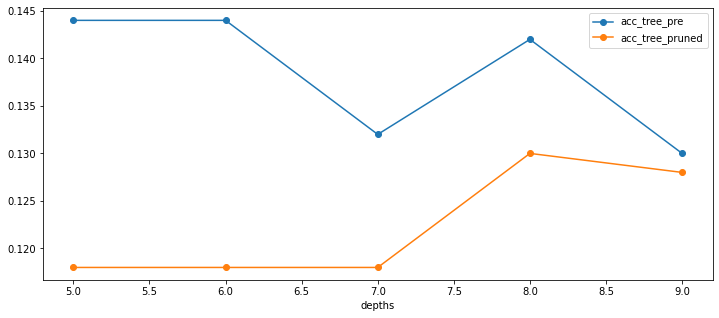

In [147]:
start_time = time.time()

# metrics dict for accuracies of our model with different depths.
metrics = {"depths": [], "acc_tree_pre": [], "acc_tree_pruned": []}

# Giving depth of 5 to 10 to test our model.
for n in range(5, 10):

    # Adding depth size for comparison visualizing
    metrics["depths"].append(n)

    # Building the tree to be used in pruning process
    tree = build_decision_tree(binned_train, max_depth=n)
    prediction = make_predictions(binned_test, tree)
    metrics["acc_tree_pre"].append(calculate_accuracy(binned_test, prediction))  # Accuracy for the pre-pruning

    # Post-pruning process
    tree_pruned = perform_post_pruning(tree, binned_train, binned_val)
    prediction = make_predictions(binned_test, tree_pruned)
    metrics["acc_tree_pruned"].append(calculate_accuracy(binned_test, prediction))  # Accuracy for the post-pruning

end_time = time.time()
print("Time taken to run the various depths:", end_time - start_time, "seconds")

df_metrics = pd.DataFrame(metrics)
df_metrics = df_metrics.set_index("depths")
print(df_metrics.plot(figsize=(12, 5), marker="o"))

# The results demonstrate that post-pruning is more accurate than pre-pruning. This is because post-pruning
# eliminates superfluous branches that could be noise or outliers in the training set, resulting in a more
# generalized tree. As a result, the model may be less susceptible to the noise in the training set and more likely
# to generalize well to new, unobserved data. Furthermore, post-pruning may be a more useful technique for managing
# unbalanced datasets with fewer samples in some classes. An overly conservative pre-pruning strategy could produce a
# biased tree that benefits the majority class. Additionally, we observed that pre-pruning is preferable in some
# max-depth values for the simple reason that post-pruning in these situations may result in an unnecessarily
# complex tree, adding noise and decreasing generalization.


After post-pruning the tree we can see that accuracy decresases for the tree with max depth 5 to 9.  
This shows that these trees has not grown enough to overfitted or maybe fit the data yet.  
   
The results demonstrate that if we raise the max_depth to be more than 9 post-pruning will be more accurate  
than pre-pruning. We know that because as we increase the max depth of tree our model will be more complex and  
eventually overfit the data. For observing this kind of result we need to run post prunning with max depth more than 9.  
   
Post-pruning eliminates superfluous branches that could be noise or outliers in the training set,resulting in a more  
generalized tree. As a result, the model may be less susceptible to the noise in the training set and more likely  
to generalize well to new, unobserved data. Furthermore, post-pruning may be a more useful technique for managing  
unbalanced datasets with fewer samples in some classes. An overly conservative pre-pruning strategy could produce a  
biased tree that benefits the majority class. Additionally, we observed that pre-pruning is preferable in some  
max-depth values for the simple reason that post-pruning in these situations may result in an unnecessarily  
complex tree, adding noise and decreasing generalization. 

4. Significance of features  
  
Features or attributes are important in determining the decisions made by the model in the context of decision  
trees. Certain features might be found to be redundant or needless for precise predictions during the pruning process.  
Knowing which features are removed and why helps make the model easier to understand and could provide light on the   
most important variables.  


5. Outline   
  
The original decision tree is presented first in the report, which is then followed by a discussion of the pruning  
procedure and a thorough analysis of the differences between the pre- and post-pruning models. The report also looks   
into the features that were removed and explains why they were removed. The objectives and context of the analysis  
are made clear in this introduction, which also sets the stage for the subsequent sections.  
